# Consigna 4
## Importación de modulos
---

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from columns_to_keep import C2K
from type_to_fix import T2F

## Carga de la tabla de metadata
---

In [2]:
data_dir = os.path.join('..', 'dataset')
data_file_name = 'datadump-20150801-20171219.csv'
full_data_file_name = os.path.join(data_dir, data_file_name)
df = pd.read_csv(full_data_file_name)
display(df.shape)

(63265, 111)

### Preprocesamiento o curación de la metadata

In [3]:
# Remuevo espacios al inicio y final del nombre de la columna
df.columns = [column.strip() for column in df.columns]

# Tomo solo las columnas que vamos a necesitar
df = df[C2K]

# Se corrigen los tipos de los datos 
df = df.astype(T2F)

display(df.shape)

(63265, 39)

## Carga la tabla de mensajes preprocesados
---

In [4]:
data_file_name = 'tiny_yup_messages_preprocessed.csv'
full_data_file_name = os.path.join(data_dir, data_file_name)
dfd = pd.read_csv(full_data_file_name)
display(dfd.shape)

(7441, 6)

## Cálculos
---
1. Se genera una nueva columna con la longitud en palabras de cada diálogo
2. Se toman las columnas `session_id`, `sent_from` y la nueva columna `twlen`
3. Se selecciona el sub grupo de turnos correspondientes a los estudiantes
4. Se computa el valor medio de la cantidad de palabras por sessión
5. Se crea la columna `student_rating` con el puntaje asignado por el alumno a la session
6. Se eliminan las las filas sin informacion (N/A)
7. Se convierte a tipo entero la variable student_rating

In [40]:
# 1.
dfd['twlen'] = dfd.text.apply(lambda x: len(x))

# 2.
dialogos = dfd[['session_id', 'sent_from','twlen']]

# 3.
dialogos = dialogos[dialogos.sent_from=='student']

# 4.
dialogos = dialogos.groupby(['session_id','sent_from']).sum()
dialogos = dialogos.reset_index()

# 5.
dialogos['student_rating'] = dialogos['session_id'].apply(lambda x:df[df.session_id==x].student_rating.values[0])

# 6.
dialogos = dialogos.dropna()

# 7.
dialogos.student_rating = dialogos.student_rating.astype(int)

display(dialogos)

,session_id,sent_from,twlen,student_rating
0,300142,student,195,3
4,300602,student,315,2
6,300833,student,32,3
8,300940,student,236,5
10,301010,student,1083,5
...,...,...,...,...
252,325522,student,1688,5
253,325796,student,129,5
254,325896,student,297,5
255,326034,student,450,5


### Histograma discrinimando cantidad de palabras de acuerdo a la calificación otorgada por el estudiante

'Relación de casos positivos a negativos 2.7547169811320753'

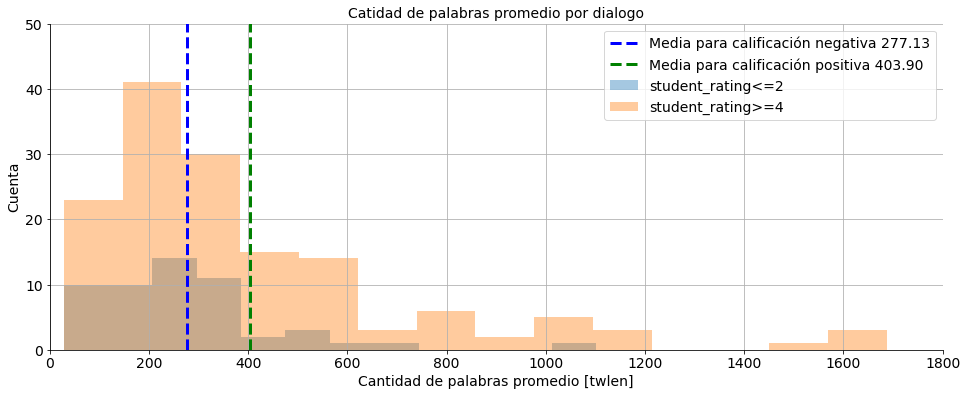

In [41]:
neg_cal = dialogos[dialogos.student_rating<=2].twlen
pos_cal = dialogos[dialogos.student_rating>=4].twlen

display(f'Relación de casos positivos a negativos {pos_cal.shape[0]/neg_cal.shape[0]}')

plt.figure(figsize=(16,6))
sns.distplot(neg_cal, kde=False, label='student_rating<=2')
sns.distplot(pos_cal, kde=False, label='student_rating>=4')
plt.plot(2*[neg_cal.mean()], [0,60], '--b', linewidth=3, label=f'Media para calificación negativa {neg_cal.mean():.2f}')
plt.plot(2*[pos_cal.mean()], [0,60], '--g', linewidth=3, label=f'Media para calificación positiva {pos_cal.mean():.2f}')
plt.grid(True)
plt.title("Catidad de palabras promedio por dialogo", fontsize=14)
plt.xlabel('Cantidad de palabras promedio [twlen]', fontsize=14)
plt.ylabel('Cuenta', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,1800])
plt.ylim([0, 50])
plt.legend(fontsize=14)
sns.despine()

### Cantidad de calificaciones vs. calificacion otorgada

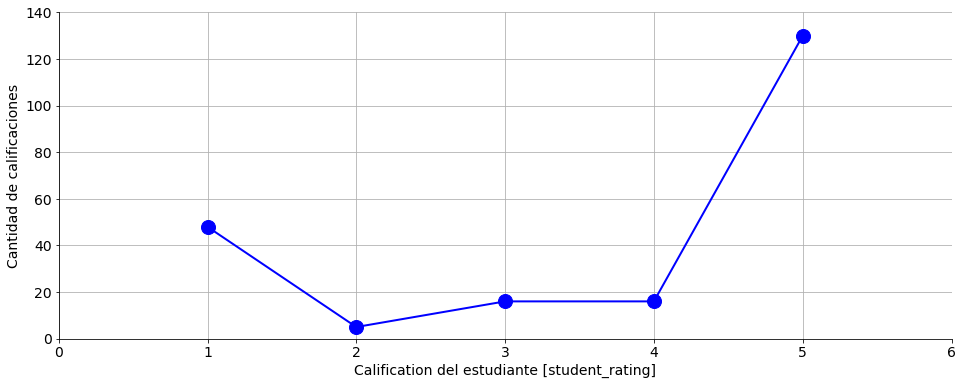

In [69]:
student_rating = list(range(1,6))
count = [dialogos[dialogos.student_rating==i].shape[0] for i in range(1,6)]

plt.figure(figsize=(16,6))
plt.plot(student_rating, count, 'b-o', linewidth=2, markersize=14)
plt.grid(True)
plt.xlabel('Calification del estudiante [student_rating]', fontsize=14)
plt.ylabel('Cantidad de calificaciones', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,6])
plt.ylim([0, 140])
sns.despine()

### Gráfico de pares para analizar cualitativamente correlación entre las variables `twlen` y `student_rating`

<Figure size 432x288 with 0 Axes>

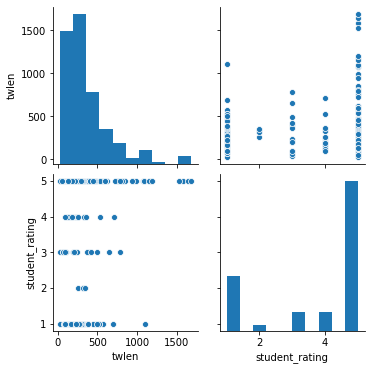

In [42]:
plt.figure()
sns.pairplot(dialogos[['twlen','student_rating']])


### Computo del coeficiente de correlacion entre las variables `twlen` y `student_rating`

In [46]:
dialogos[['twlen', 'student_rating']].corr(method='spearman')

,twlen,student_rating
twlen,1.000000,0.205918
student_rating,0.205918,1.000000


### Análisis

* El promedio de palabras por dialogo entre caso con calificación positiva y negativa difiere considerablemente (~130 palabras más para los casos con calificación positiva). 
* Un aspecto a resaltar es que la cantidad de casos con calificacion positiva es ~2.75 veces superior al caso con calificación negativa.
* Cualitativamente, a partir de los gráficos del tipo pairplot no se puede apreciar una tendencia conjunta o correlación entre las variable.
* El coputo del coficiente de correlación confirma la observacion del el análisis cualitivo.